In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import re
import pickle
from darts.timeseries import TimeSeries
from darts.models import RegressionModel
from sklearn.linear_model import Ridge
from darts.utils.missing_values import fill_missing_values as darts_fill_na
from darts.dataprocessing import Pipeline
from darts.dataprocessing.transformers import Scaler, StaticCovariatesTransformer, InvertibleMapper

In [2]:
csv_dfs = {}
csv_dfs['bq-results-20240418-170723-1713460063623'] = pd.read_csv('data/bq-results-20240418-170723-1713460063623.csv')

# Training

## Process Data

In [3]:
biometrics = csv_dfs['bq-results-20240418-170723-1713460063623']
biometrics.drop_duplicates(subset=['CloudId', 'BiometricName', 'MeasuredOnUTC', 'Value'], keep='first', inplace=True)

def clean_timestamp(ts_str):
    clean_str = re.sub(r'(\d+:\d+:\d+)(\.\d+)?', r'\1', ts_str)
    return clean_str

biometrics['MeasuredOn'] = biometrics['MeasuredOnUTC'].apply(clean_timestamp)
biometrics['MeasuredOn'] = pd.to_datetime(biometrics['MeasuredOn'], errors='coerce')
biometrics['MeasuredOnDate'] = biometrics['MeasuredOn'].dt.date
biometrics['MeasuredOnDay'] = biometrics['MeasuredOn'].dt.dayofyear
biometrics['MeasuredOnWeek'] = biometrics['MeasuredOnDay'] // 7
biometrics.sort_values('MeasuredOnWeek', inplace=True)

In [4]:
bms = biometrics.drop(columns=['Age', 'Gender', 'MeasureProvidedBy', 'MeasuredOnUTC', 'MeasuredOnDay', 'MeasuredOn', 'MeasuredOnDate'])
bms = bms.groupby(['CloudId', 'BiometricName', 'MeasuredOnWeek']).agg({'Value': 'mean'}).reset_index()
bms.sample(5)

,CloudId,BiometricName,MeasuredOnWeek,Value
232024,6e1b110b8c499398e8abbbce1781edbcc4d60742,Right Leg Muscle Mass,19,11.3
94158,2c24a6198cb11adc2f83055653c8d53fd49b2392,HR At Rest,19,58.0
72566,227ab9c8dd2eb94a0fde77cadb6e1498e9cd4d1b,Standard Muscle Mass Perc,25,58.9
377036,b0dc2b007409cc5a3cf920debc9b87dc11b25a4d,Left Arm Muscle Mass,19,2.8
339408,9ef059144968f5289762d00773b8ddb5fb9c8360,HR At Rest,48,106.5


In [5]:
grouped_bms = bms.groupby(['CloudId', 'BiometricName']).agg({'MeasuredOnWeek': [list, 'count'], 'Value': list})
grouped_bms = grouped_bms.reset_index()
grouped_bms.sample(5)

CloudId           BiometricName  \
                                                                           
227528  f8eae335573bdaa65e8638ca01df58a946e04fda  Left Arm Fat Free Mass   
196895  d7afd22ec07929a846562f409f124f006ef3d790  Degree Of Obesity Perc   
210957  e743086fec1e47d61780694c2bb35077014541ab    Extra Cellular Water   
145619  a09c6738fd52f69e92b4be29ad8ba09dc3eff48a       Left Leg Fat Mass   
72388   4f350c466e95f722491c321b42d0b93e2197a9b0                     BMI   

              MeasuredOnWeek                                 Value  
                        list count                            list  
227528      [18, 37, 48, 50]     4            [1.8, 1.8, 1.8, 1.8]  
196895                  [32]     1                          [12.2]  
210957  [21, 27, 30, 37, 46]     5  [18.3, 18.3, 18.0, 18.0, 18.3]  
145619                  [37]     1                           [3.6]  
72388           [37, 46, 48]     3              [26.1, 25.8, 25.3]

Use only (CloudId, BiometricName) pairs with more than 3 measurements

In [6]:
grouped_long_bms = grouped_bms[grouped_bms[('MeasuredOnWeek', 'count')] > 3]
print(f'Sequences with more than 3 weeks of data:\t{len(grouped_long_bms)}')
print(f'Total number of sequences:\t\t\t{len(grouped_bms)}')

Sequences with more than 3 weeks of data:	39474
Total number of sequences:			234079


In [7]:
long_bms = grouped_long_bms.explode(column=[('MeasuredOnWeek', 'list'), ('Value', 'list')], ignore_index=True)
long_bms = long_bms.drop(columns=[('MeasuredOnWeek', 'count')])
long_bms.columns = [col[0] for col in long_bms.columns]
long_bms = long_bms.astype({'MeasuredOnWeek': 'int32', 'Value': 'float64'})
long_bms.sample(5)

,CloudId,BiometricName,MeasuredOnWeek,Value
195936,cd7844ef3783105af997ec3635539d823988b694,Left Arm Muscle Mass,16,2.100000
134476,876fed2ad3fb1efb40ca76eeaab7c566f2386a63,Waist-Hip ratio,37,0.890000
178862,b896323f0519c742cebfe9b1b8d864cb81a5c2f9,Fat Free Mass,16,54.300000
71245,4b4c87f9636eab62d2b693507620003f86038b37,Left Leg Fat Perc,17,12.900000
21483,12c0e9a42836cd76fcace11d7d5dfcc9b09356b7,Diastolic Blood Pressure,48,86.333333


Compute time series for each Cloud ID, Biomertric pair

In [8]:
df = long_bms.groupby(['CloudId', 'BiometricName']).agg({'MeasuredOnWeek': list, 'Value': list}).reset_index()
df.sample(5)

,CloudId,BiometricName,MeasuredOnWeek,Value
24473,997bad3eada72d0cbfdc93ee89af132881486d3d,Left Arm Fat Perc,"[16, 18, 19, 26, 27]","[14.0, 14.2, 13.0, 12.7, 12.1]"
34225,e08bdc044a18d842942dc01477e6f251e33ae142,Right Leg Fat Free Mass,"[18, 28, 46, 52]","[11.0, 10.5, 11.0, 11.1]"
6106,24b9d3f71d3974f6990b37c1b7c7021db97ff62b,Right Leg Muscle Mass Score,"[18, 19, 26, 28, 30, 32, 37, 41, 46, 48]","[1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 2.0, 2.0, 2.0, ..."
25275,9ee89b5d6144aee9a0f878ec5bf8a8df983701f1,Trunk Fat Free Mass,"[17, 18, 19, 21, 26, 28, 36, 37, 39, 48, 50, 52]","[28.7, 28.3, 28.1, 28.2, 28.1, 28.4, 28.1, 28...."
15518,64037b9854f2fc74acc78b474f1f3ed1430edfef,Right Arm Fat Perc,"[19, 26, 27, 28, 37, 39, 46, 48, 50]","[14.9, 15.2, 14.2, 14.6, 15.15, 15.6, 15.4, 15..."


Store users with a lot of data to use for demo purposes

In [39]:
long_df = df[df.MeasuredOnWeek.apply(lambda x: max(x) - min(x) >= 25)]
long_df.to_pickle('processed_biometrics.pkl')

- Add gender and age as static covariates
- Exercise features and height can be encoded either as static or as dynamic covariates
- Finally each timeseries should use the rest of the biometrics as dynamic covariates (e.g. weight timeseries should use fat perc, mucle perc etc. as dynamic covariates)

In [9]:
static_cov_df = biometrics[['CloudId', 'Gender', 'Age']].drop_duplicates(subset='CloudId')
df = df.merge(static_cov_df, on='CloudId')

In [10]:
def create_and_fill_timeseries(row):
    times = pd.Index(row['MeasuredOnWeek'])
    values = row['Value']
    covs = pd.DataFrame(data={ 'Gender': [row['Gender']], 'Age': [row['Age']] })
    ts = TimeSeries.from_times_and_values(times=times, values=values, static_covariates=covs, freq=1)
    filled_ts = darts_fill_na(ts, fill='auto').astype(np.float32)
    return filled_ts

In [11]:
df['time_series'] = df.apply(create_and_fill_timeseries, axis=1)

In [12]:
train_df = df.drop(columns=['Age', 'Gender', 'MeasuredOnWeek', 'Value'])

Set up data normalization pipeline

In [13]:
static_cov_transformer = StaticCovariatesTransformer(name="Encoder")
log_transformer = InvertibleMapper(np.log1p, np.expm1, verbose=False, n_jobs=-1, name="Log-Transform")   
train_scaler = Scaler(verbose=False, n_jobs=-1, name="Scaling")
preprocess_pipeline = Pipeline([static_cov_transformer, log_transformer])

## Fit Model

In [14]:
target_bm = 'Weight'

In [15]:
train_set = train_df[train_df.BiometricName == 'Weight'].time_series.tolist()

Shift sequences so they start at week 0 and filter out time sequences with durantion less than 25 weeks.

In [16]:
shifted_train_set = [x.shift(-x.time_index.start) for x in train_set if x.end_time() >= 25]
sliced_train_set = [x.slice(0,25) for x in shifted_train_set if x.end_time() >= 25]

In [17]:
train_set_transf = preprocess_pipeline.fit_transform(sliced_train_set)

In [91]:
model = RegressionModel(
    model=Ridge(),
    lags=8,
    output_chunk_length=4
)
model.fit(train_set_transf)

RegressionModel(lags=8, lags_past_covariates=None, lags_future_covariates=None, output_chunk_length=4, output_chunk_shift=0, add_encoders=None, model=Ridge(), multi_models=True, use_static_covariates=True)

In [163]:
preds = model.predict(12, train_set_transf)
unnorm_preds = preprocess_pipeline.inverse_transform(preds, partial=True)

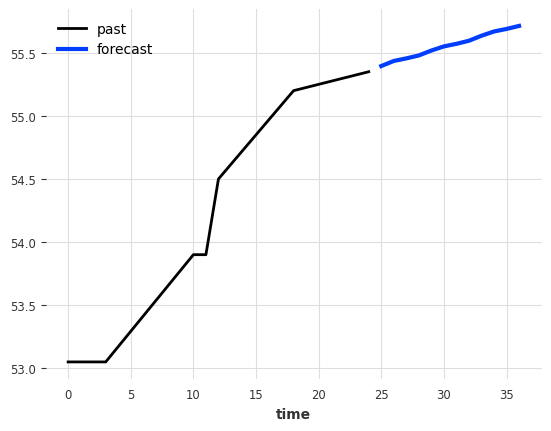

In [221]:
i = np.random.randint(0, len(sliced_train_set))
sliced_train_set[i].plot(label='past')
unnorm_preds[i].plot(label='forecast', lw=3)
plt.legend()
plt.show()

Save model and data preprocessor

In [112]:
model.save("weight_model.pkl")

In [113]:
pickle.dump(preprocess_pipeline, open('weight_preprocessor.pkl', 'wb'))

# Inference

In [3]:
model = RegressionModel.load("weight_model.pkl")
preprocess_pipeline = pickle.load(open('weight_preprocessor.pkl', 'rb'))

In [4]:
def create_and_fill_timeseries(row):
    times = pd.Index(row['MeasuredOnWeek'])
    values = row['Value']
    covs = pd.DataFrame(data={ 'Gender': [row['Gender']], 'Age': [row['Age']] })
    ts = TimeSeries.from_times_and_values(times=times, values=values, static_covariates=covs, freq=1)
    filled_ts = darts_fill_na(ts, fill='auto').astype(np.float32)
    return filled_ts

In [5]:
# Use samples from the dataset
# weeks = sliced_train_set[i].time_index
# values = sliced_train_set[i].values()
# covs = sliced_train_set[i].static_covariates

# Use your own values
weeks = pd.Index([0,4,10,16,21,24,26])
values = [82, 84, 85, 82, 84, 86, 87][::-1]
covs = pd.DataFrame(data={'Gender': ['M'], 'Age': [30]})

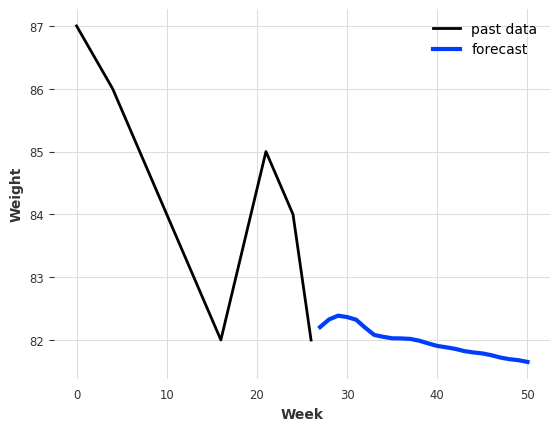

In [7]:
ts = TimeSeries.from_times_and_values(times=weeks, values=values, static_covariates=covs, freq=1)
filled_ts = darts_fill_na(ts, fill='auto').astype(np.float32)

trans_ts = preprocess_pipeline.transform(filled_ts)
pred = model.predict(24, [trans_ts])
unnorm_pred = preprocess_pipeline.inverse_transform(pred)[0]

filled_ts.plot(label='past data')
unnorm_pred.plot(label='forecast', lw=3)
plt.xlabel('Week')
plt.ylabel('Weight')
plt.show()

# Get a user's data

In [45]:
processed_biometrics = pd.read_pickle('processed_biometrics.pkl')
valid_cloud_ids = processed_biometrics.CloudId.unique()

In [ ]:
targets = ['Weight', 'Fat mass Perc', 'Muscle Mass', 'HR at Rest']

In [68]:
i = np.random.randint(0, len(valid_cloud_ids))
cloud_id = valid_cloud_ids[i]

In [77]:
user_bms = processed_biometrics[(processed_biometrics.CloudId == cloud_id) & (processed_biometrics.BiometricName.isin(targets))]
user_bms_filtered = user_bms[['BiometricName', 'MeasuredOnWeek', 'Value', 'Gender', 'Age']]
user_bms_filtered

,BiometricName,MeasuredOnWeek,Value,Gender,Age
22390,Fat mass Perc,"[19, 39, 46, 50]","[40.2, 38.3, 40.6, 39.0]",F,20
22407,Muscle Mass,"[19, 39, 46, 50]","[53.4, 54.9, 51.7, 53.3]",F,20
22435,Weight,"[19, 39, 46, 50]","[94.0, 93.7, 91.7, 92.0]",F,20


In [86]:
user_gender = user_bms_filtered['Gender'].iloc[0]
user_age = user_bms_filtered['Age'].iloc[0]

biometric_data_list = user_bms_filtered.drop(['Gender', 'Age'], axis=1).to_dict(orient='records')

In [91]:
biometric_data_list

[{'BiometricName': 'Fat mass Perc',
  'MeasuredOnWeek': [19, 39, 46, 50],
  'Value': [40.2, 38.3, 40.6, 39.0]},
 {'BiometricName': 'Muscle Mass',
  'MeasuredOnWeek': [19, 39, 46, 50],
  'Value': [53.4, 54.9, 51.7, 53.3]},
 {'BiometricName': 'Weight',
  'MeasuredOnWeek': [19, 39, 46, 50],
  'Value': [94.0, 93.7, 91.7, 92.0]}]